# CSE-CIC-IDS 2017

In [1]:
model_id = "rnn9-binary"

In [2]:
import numpy as np
np.random.seed(42)
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

import glob, time, os

import keras

Using TensorFlow backend.
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Us

In [3]:
NOTEBOOK_PATH = "C:/Users/Xetrov/Desktop/SciFair20/Code/"

In [4]:
x_scaled = pd.read_csv(NOTEBOOK_PATH + "IDS2017/x_scaled_powertransform.csv")
y_df_enc = pd.read_csv(NOTEBOOK_PATH + "IDS2017/y_all_binary.csv")

In [5]:
x_scaled_npy = np.expand_dims(x_scaled.to_numpy(), axis=-1)

In [6]:
x_scaled_npy.shape

(2830743, 68, 1)

# Split data into train and test

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
x_train, x_valtest, y_train, y_valtest = train_test_split(x_scaled_npy, y_df_enc, test_size = 0.4, random_state = 42)

In [9]:
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size = 0.5, random_state = 42)

In [10]:
del x_train
del y_train
del x_valtest 
del y_valtest

# Load ADASYN data

In [12]:
x_train_res = pd.read_csv(NOTEBOOK_PATH + "IDS2017/x_adasyn_binary.csv")

In [13]:
y_train_res = pd.read_csv(NOTEBOOK_PATH + "IDS2017/y_adasyn_binary.csv")['IsAttack']

In [14]:
x_train_resnpy = np.expand_dims(x_train_res, axis=-1)

# Train model

In [15]:
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, BatchNormalization, Dropout, InputLayer, GRU, CuDNNGRU
from keras.optimizers import SGD, Adam

In [17]:
def addDenseBlock(model, units, **params):
    model.add(Dense(units=units, activation=params['hidden_activation'], input_dim=x_train_resnpy.shape[1]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))

def addLSTMBlock(model, units, return_sequences=False, **params):
    model.add(LSTM(units=units, return_sequences=return_sequences, input_shape=x_train_resnpy.shape[1:]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))
        
def addCuDNNLSTMBlock(model, units, return_sequences=False, **params):
    model.add(CuDNNLSTM(units=units, return_sequences=return_sequences, input_shape=x_train_resnpy.shape[1:]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))

def addGRUBlock(model, units, return_sequences=False, **params):
    model.add(GRU(units=units, return_sequences=return_sequences, input_shape=x_train_resnpy.shape[1:]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))
        
def addCuDNNGRUBlock(model, units, return_sequences=False, **params):
    model.add(CuDNNGRU(units=units, return_sequences=return_sequences, input_shape=x_train_resnpy.shape[1:]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))
        
def createModel(**in_params):
    """
    Supported parameters:
    batch_normalization - True or False
    dropout_rate - 0 to 1
    num_units - integer
    learning_rate - float
    activation_function - string
    """
    
    model = Sequential()

    # Set default values
    params = {
        'batch_normalization': False,
        'dropout_rate': 0,
        'num_layers': 6,
        'num_units': 128,
        'learning_rate': 0.001,
        'hidden_activation': 'relu',
        'final_activation': 'sigmoid'
    }
    
    # Replace defaults with specified parameters
    for param in in_params:
        params[param] = in_params[param]    
    
    # InputLayer causes serialization issues
#     model.add( InputLayer(input_shape = (x_train.shape[1],) ) )
    
#     for i in range(params['num_layers']):
#         addDenseBlock(model, params['num_units'], **params)

    addCuDNNLSTMBlock(model, 128, return_sequences=True, **params)
    addCuDNNLSTMBlock(model, 128, return_sequences=True, **params)
    addCuDNNLSTMBlock(model, 256, return_sequences=True, **params)
    addCuDNNLSTMBlock(model, 256, return_sequences=True, **params)
    addCuDNNLSTMBlock(model, 128, return_sequences=True, **params)
    addCuDNNLSTMBlock(model, 128, return_sequences=False, **params)

    model.add(Dense(units=1, activation=params['final_activation']))

    # optim = SGD(lr=0.001, nesterov=True)
    optim = Adam(lr=params['learning_rate'])

    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    
#     print(params)
    
    return model

Ensure a GPU is available

In [18]:
import keras.backend as K

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Callbacks

In [19]:
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

def timestamp():
    return time.strftime("%m-%d-%Y, %I%M%p")

csv_callback = CSVLogger(NOTEBOOK_PATH + 'Loss Logs/%s (%s)' % (model_id, timestamp()), append=True)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0.0001, patience=5)

### Model Saving

In [20]:
savedir = NOTEBOOK_PATH + "Models/%s/" % model_id
if not os.path.exists(savedir):
    os.makedirs(savedir)
    print("Created " + savedir)
else:
    print("Using " + savedir)

Created C:/Users/Xetrov/Desktop/SciFair20/Code/Models/rnn9-binary/


### Training

In [21]:
import itertools

trainEpochs = 200

parameters = {'batch_size': 1000, 'batch_normalization':True,'dropout_rate':0}

In [22]:
%%time
print(model_id)
# model = keras.models.load_model(NOTEBOOK_PATH + "Models/%s/rnn(10).h5" % model_id)
model = createModel(**parameters)
model.summary()
model_checkpoint = ModelCheckpoint(NOTEBOOK_PATH + "Models/%s/rnn({epoch}).h5" % (model_id), monitor='val_loss')
model.fit(x_train_resnpy, y_train_res, validation_data=(x_val, y_val), batch_size=parameters['batch_size'], epochs=trainEpochs, verbose=2, callbacks=[csv_callback, model_checkpoint])

rnn9-binary
Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 68, 128)           67072     
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 128)           512       
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 68, 128)           132096    
_________________________________________________________________
batch_normalization_2 (Batch (None, 68, 128)           512       
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 68, 256)           395264    
_________________________________________________________________
batch_normalization_3 (Batch (None, 68, 256)           1024      
_________________________________________________________

# Graph the losses

In [23]:
def most_recent_file(pattern):
    return max(glob.iglob(pattern, recursive=True), key=os.path.getctime)

logpath = most_recent_file(NOTEBOOK_PATH + "Loss Logs/%s**" % model_id)
log_df = pd.read_csv(logpath)
log_df['epoch'] += 1

print(logpath)

C:/Users/Xetrov/Desktop/SciFair20/Code/Loss Logs\rnn9-binary (10-30-2019, 0945PM)


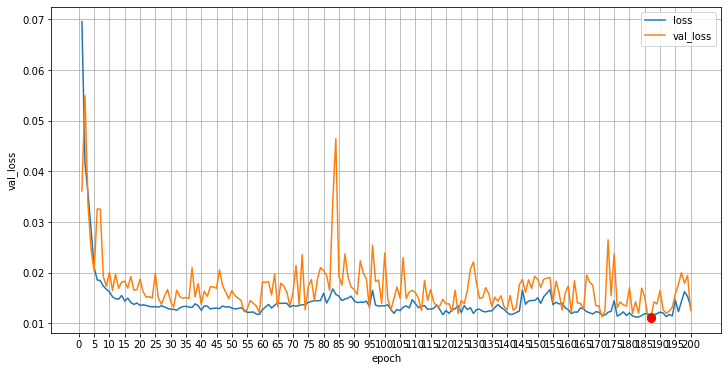

In [24]:
plot_df = log_df[:]

metric = 'loss'

plt.figure(figsize=(12,6))
sns.lineplot(x='epoch', y=metric, data=plot_df, label=metric)
sns.lineplot(x='epoch', y='val_'+metric, data=plot_df, label='val_'+metric)
plt.legend()

minEpoch = plot_df.loc[plot_df.idxmin()[metric]]
plt.plot((minEpoch['epoch']), (minEpoch[metric]), 'go', markersize=8)
minEpoch = plot_df.loc[plot_df.idxmin()['val_'+metric]]
plt.plot((minEpoch['epoch']), (minEpoch['val_'+metric]), 'ro', markersize=8)

plt.xticks(list(range(0, plot_df['epoch'].max()+1, 5)))
# plt.yticks(list(np.arange(0.0,0.4,0.05)))

plt.grid(True)

# Test Data

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [26]:
model = keras.models.load_model(NOTEBOOK_PATH + "Models/%s/rnn(187).h5" % model_id)

In [27]:
pred = model.predict(x_test).round().astype('int').ravel()
y_test_npy = y_test.to_numpy().ravel()

precision = precision_score(y_test_npy, pred)
print("Precision:", precision)

recall = recall_score(y_test_npy, pred)
print("Recall:", recall)

f1 = f1_score(y_test_npy, pred)
print("F1:", f1)

Precision: 0.988785412149433
Recall: 0.9992007830530087
F1: 0.9939658137218558


In [28]:
pred_series = pd.Series(pred, name="Pred").replace({0: 'Benign', 1: 'Attack'})
y_series = pd.Series(y_test.to_numpy().ravel(), name="Actual").replace({0: 'Benign', 1: 'Attack'})

matrix = pd.crosstab(pred_series, y_series, margins=True)
matrix

Actual,Attack,Benign,All
Pred,,,
Attack,111270,1262,112532
Benign,89,453528,453617
All,111359,454790,566149


# Log results

In [35]:
model_log = open(NOTEBOOK_PATH + "model_log.txt", "a")

model_log.write("\n" + model_id)
model_log.write("\n\tF1 Micro: " + str(f1_micro))
model_log.write("\n\tF1 Macro: " + str(f1_macro))

model_log.close()